In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

In [10]:
# WGAN Generator
class WGANGenerator(nn.Module):
    def __init__(self, noise_dim=100):
        super(WGANGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 4 * 4 * 512),
            nn.ReLU(inplace=True),
            nn.Unflatten(1, (512, 4, 4)),
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

# WGAN Critic
class WGANCritic(nn.Module):
    def __init__(self):
        super(WGANCritic, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(4 * 4 * 512, 1)
        )

    def forward(self, img):
        return self.model(img)

In [11]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

Files already downloaded and verified


In [14]:
noise_dim = 100
lr = 0.00005
num_epochs = 50
# batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = WGANGenerator(noise_dim).to(device)
critic = WGANCritic().to(device)

optimizer_G = optim.RMSprop(generator.parameters(), lr=lr)
optimizer_C = optim.RMSprop(critic.parameters(), lr=lr)

clip_value = 0.01
critic_iterations = 5

Epoch [1/50], C Loss: -1.4286, G Loss: 0.7078
Epoch [2/50], C Loss: -1.5062, G Loss: 0.7584
Epoch [3/50], C Loss: -1.5438, G Loss: 0.7676
Epoch [4/50], C Loss: -1.5331, G Loss: 0.7622
Epoch [5/50], C Loss: -1.5122, G Loss: 0.7574
Epoch [6/50], C Loss: -1.5690, G Loss: 0.7792
Epoch [7/50], C Loss: -1.5787, G Loss: 0.7782
Epoch [8/50], C Loss: -1.5814, G Loss: 0.7795
Epoch [9/50], C Loss: -1.5800, G Loss: 0.7798
Epoch [10/50], C Loss: -1.5876, G Loss: 0.7861
Epoch [11/50], C Loss: -1.5830, G Loss: 0.7848
Epoch [12/50], C Loss: -1.5880, G Loss: 0.7862
Epoch [13/50], C Loss: -1.5820, G Loss: 0.7823
Epoch [14/50], C Loss: -1.5844, G Loss: 0.7845
Epoch [15/50], C Loss: -1.5869, G Loss: 0.7858
Epoch [16/50], C Loss: -1.5881, G Loss: 0.7865
Epoch [17/50], C Loss: -1.5870, G Loss: 0.7857
Epoch [18/50], C Loss: -1.5844, G Loss: 0.7861
Epoch [19/50], C Loss: -1.5872, G Loss: 0.7860
Epoch [20/50], C Loss: -1.5880, G Loss: 0.7862
Epoch [21/50], C Loss: -1.5832, G Loss: 0.7855
Epoch [22/50], C Loss:

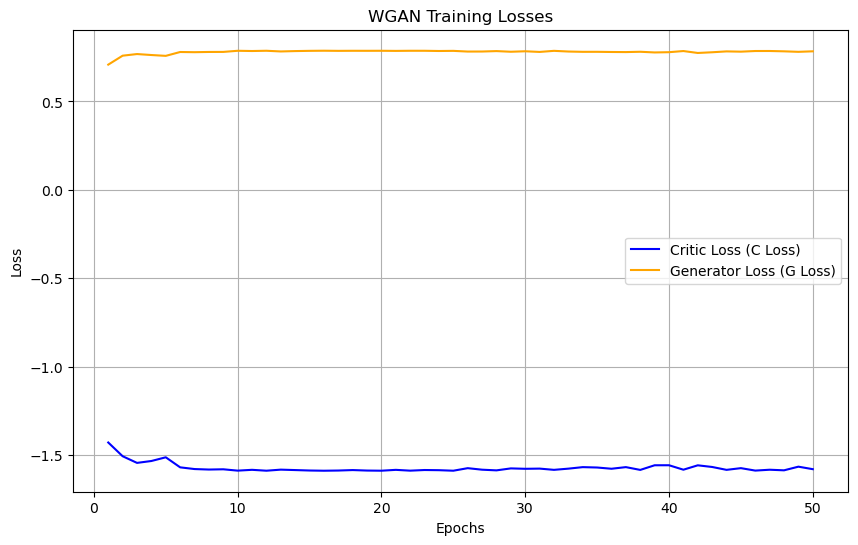

In [15]:
import matplotlib.pyplot as plt

critic_losses = []
generator_losses = []

# Training loop
for epoch in range(num_epochs):
    epoch_c_loss = 0.0
    epoch_g_loss = 0.0
    num_batches = 0

    for i, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)
        num_batches += 1

        for _ in range(critic_iterations):
            optimizer_C.zero_grad()

            real_loss = -torch.mean(critic(real_imgs))

            z = torch.randn(batch_size, noise_dim, device=device)
            fake_imgs = generator(z)
            fake_loss = torch.mean(critic(fake_imgs.detach()))

            # total Critic loss
            c_loss = real_loss + fake_loss
            c_loss.backward()
            optimizer_C.step()

            # clip critic weights
            for p in critic.parameters():
                p.data.clamp_(-clip_value, clip_value)

        epoch_c_loss += c_loss.item()

        optimizer_G.zero_grad()

        z = torch.randn(batch_size, noise_dim, device=device)
        fake_imgs = generator(z)
        g_loss = -torch.mean(critic(fake_imgs))

        g_loss.backward()
        optimizer_G.step()

        epoch_g_loss += g_loss.item()

    # avg losses
    avg_c_loss = epoch_c_loss / num_batches
    avg_g_loss = epoch_g_loss / num_batches

    critic_losses.append(avg_c_loss)
    generator_losses.append(avg_g_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], C Loss: {avg_c_loss:.4f}, G Loss: {avg_g_loss:.4f}")

# Plot losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), critic_losses, label="Critic Loss (C Loss)", color="blue")
plt.plot(range(1, num_epochs + 1), generator_losses, label="Generator Loss (G Loss)", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("WGAN Training Losses")
plt.legend()
plt.grid()
plt.show()


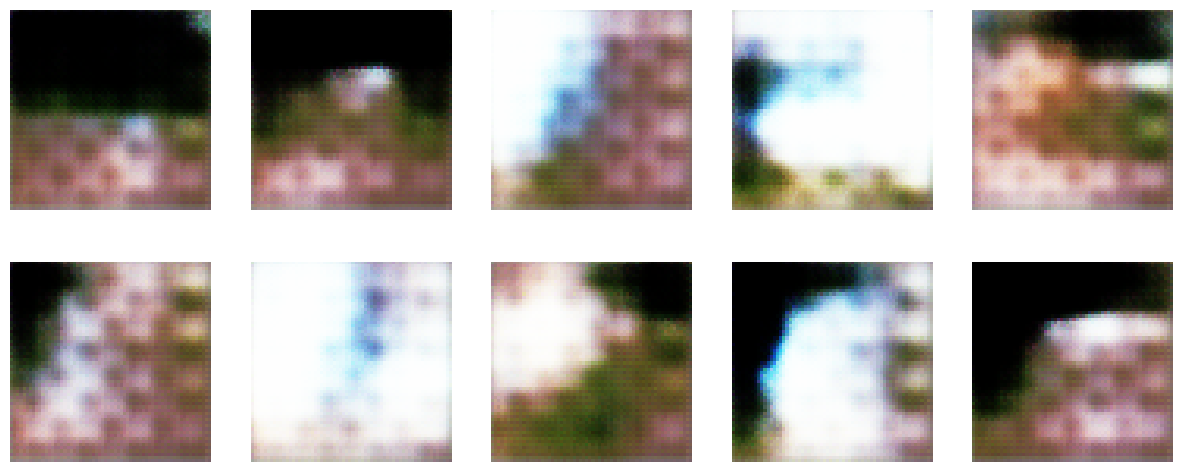

In [21]:
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_images = 10

noise_dim = 100
z = torch.randn(num_images, noise_dim, device=device)

generator.eval()  # setting the generator to evaluation mode
with torch.no_grad():
    generated_images = generator(z)

generated_images = generated_images.cpu().numpy()

# for saving images
save_dir = 'wgan_generated_images'
os.makedirs(save_dir, exist_ok=True)

for i in range(num_images):
    image = generated_images[i].transpose(1, 2, 0)
    image = (image + 1) / 2
    plt.imsave(os.path.join(save_dir, f'generated_image_{i+1}.png'), image)


fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(num_images):
    image = generated_images[i].transpose(1, 2, 0)
    image = (image + 1) / 2
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()
